## Initial design generator using warmstarting

In [1]:
import numpy as np
import subprocess
import os

# Fallback: Set the key directly in the script (for debugging only)
if not os.getenv('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = 'key'

def initial_generator(dim,mn,mx,n):
    script_path = "/Users/chih-yuchang/Desktop/Research/LLMIBO/initial.py"
    result = subprocess.run(['python3', script_path,str(dim), str(mn), str(mx), str(n)], capture_output=True, text=True)
    input_text = result.stdout.replace('(', '').replace(')', '').replace('\n', '').replace(',', '')

    initial = input_text.split()

    # Convert the strings into pairs of floats, reshape into a 2D array
    initial_design = np.array(initial, dtype=float).reshape(-1, dim)
    return initial_design



## Black box function

In [4]:
def ackley_1d(x, noise_std=0.1):

    # Calculate the Ackley function for each element in x
    out = (-20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2))) 
           - np.exp(0.5 * (np.cos(2 * np.pi * x))) 
           + np.e + 20)
    
    # Generate Gaussian noise for each input independently
    noise = np.random.normal(0, noise_std, size=x.shape)
    
    # Add noise to the output
    noisy_output = -1*out + noise
    
    return noisy_output.reshape(-1,1)

def levy_with_noise_2d(input_array, noise_std=0.1):
    if noise_std < 0:
        raise ValueError("Standard deviation of noise must be non-negative.")
    
    # Separate the 2D input array into x and y components
    x = input_array[:, 0]  # First column is x
    y = input_array[:, 1]  # Second column is y
    
    w1 = 1 + (x - 1) / 4
    w2 = 1 + (y - 1) / 4
    term1 = np.sin(np.pi * w1)**2
    term2 = (w1 - 1)**2 * (1 + 10 * np.sin(np.pi * w1 + 1)**2)
    term3 = (w2 - 1)**2 * (1 + np.sin(2 * np.pi * w2)**2)
    
    # Add Gaussian noise (Ensure noise_std is valid)
    noise = np.random.normal(0, noise_std, size=x.shape)
    
    # Combine terms and add noise
    result = -term1 - term2 - term3 + noise
    
    # Reshape the result to be a 2D array with shape (n_samples, 1)
    return result.reshape(-1, 1)

## LLM candidates generator 

In [5]:
import random
def LLM_generator(historical_x,historical_f,alp,required_num,mn,mx):
    cand = np.empty((0, len(historical_x[0])))  # Assuming each vector has 3 elements
    criterion = np.max(historical_f)-alp*(np.max(historical_f)- np.min(historical_f))
    dim=len(historical_x[0])
    for n in range(required_num):
        per = np.random.permutation(len(historical_x))
        per_x = historical_x[per]
        per_f = historical_f[per]
        comment = f"The following are examples of the black box function realizations and the corresponding inputs. The input is {dim} dimension where each dimension is bounded by {mn} and {mx}. Recommend a input with dimension {dim}, each dimension is bounded between {mn} and {mx}, that can achieve the target realization of {criterion}. Do not recommend input at the minimum or maximum of allowable range, do not recommend rounded values. Recommend values with the highest possible precision. Your response must only contain the predicted input inside () and do not include any space inside the tuple.  Do not include any additional text or explanation. \n"
        for i in range(len(historical_x)):
            comment = comment + f' function realization: {per_f[i]} with input ('
            for j in range(dim):
                comment = comment + f'{per_f[0].item()}'
                if j != (dim-1):
                    comment = comment +','
            comment = comment + ')\n'


        comment = comment + f'function realization: {criterion} with input:'
        script_path = "/Users/chih-yuchang/Desktop/Research/LLMIBO/generator.py"
        result = subprocess.run(['python3', script_path,comment], capture_output=True, text=True)
        input_text = result.stdout.replace('(', '').replace(')', '')
        v = list(map(float, input_text.split(',')))
        cand = np.vstack([cand, v])

    return cand.astype(float)

## GP candidates generator

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

def create_grid(dim, mn, mx, num_points):
    # Create an array of points for each dimension
    points = np.linspace(mn, mx, num_points)
    
    # Create a meshgrid for the specified number of dimensions
    grid = np.meshgrid(*([points] * dim))  # Repeat points for each dimension
    
    # Stack the grids to create a single array of shape (num_points^dim, dim)
    grid_stacked = np.vstack(list(map(np.ravel, grid))).T
    
    return grid_stacked

def GP_generator(historical_x,historical_f,den,required_num,dim,mn,mx):
    # let us use the Matern kernel
    K = 1.0 * Matern(length_scale=0.1, length_scale_bounds=(1e-2, 100), nu=0.5)
    gp = GaussianProcessRegressor(kernel=K)
    gp.fit(historical_x, historical_f)
    X_grid =  create_grid(dim, mn, mx, den)
    samples = gp.sample_y(X_grid, n_samples=required_num)
    column_max = np.argmax(samples, axis=0)

    return np.array(X_grid[column_max])

## Mixture of normal optimizer 

In [57]:
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture


def mixture_normal_optimizer(LLM_cand, GP_cand, lamb, mn, mx):
    def mixture_pdf(x,LLM_cand,GP_cand):
        x = x.reshape(-1, len(LLM_cand[0]))  # Ensure x has the correct shape
        gmm = GaussianMixture(n_components=1)  # Assuming two components, adjust as needed
        mod_LLM = gmm.fit(LLM_cand)
        pdf_LLM = np.exp(mod_LLM.score_samples(x))
        
        gmm = GaussianMixture(n_components=1)  # Assuming two components, adjust as needed
        mod_GP = gmm.fit(GP_cand)
        pdf_GP = np.exp(mod_GP.score_samples(x))
        return lamb * pdf_GP + (1 - lamb) * pdf_LLM

    # Define an objective function to minimize (negative of the mixture PDF)
    def objective_function(x):
        return mixture_pdf(x, LLM_cand,GP_cand)

    # Set bounds for the optimization if needed (example: a box around the means)
    X_grid = create_grid(len(LLM_cand[0]),mn,mx,10000)
    result = X_grid[np.argmax(objective_function(X_grid))]
    return result



## Compile all together

In [49]:
def LLMIBO(dim,mn,mx,n_init,n_iter,n_sam,n_est,f,alp):
    data_x = initial_generator(dim,mn,mx,n_init)
    data_f = f(data_x)
    for i in range(n_iter):
        print(i)
        LLM_candidates = LLM_generator(data_x,data_f,alp,n_sam,mn,mx)
        GP_candidates = GP_generator(data_x,data_f,n_est,n_sam,dim,mn,mx)
        x_n = mixture_normal_optimizer(LLM_candidates,GP_candidates,(i+1)/n_iter,mn,mx).reshape(1, -1)
        f_n = f(x_n)
        data_x = np.vstack([data_x,x_n])
        data_f = np.vstack([data_f,f_n])
    return data_x, data_f

## Code for generate figure 3

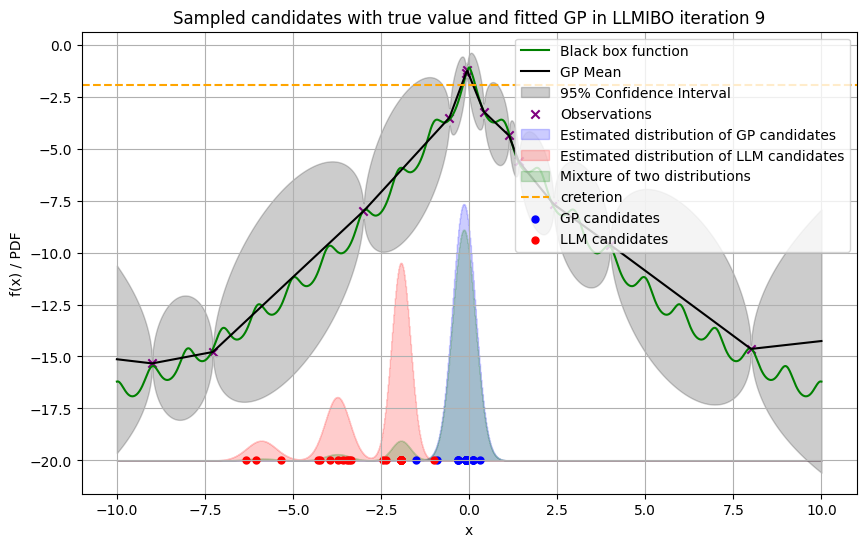

In [94]:
import matplotlib.pyplot as plt

data_x = initial_generator(1,-10,10,4)
data_f = ackley_1d(data_x)
LLM_candidates = LLM_generator(data_x,data_f,0.05,30,-10,10)
GP_candidates = GP_generator(data_x,data_f,100,30,1,-10,10)

K = 1.0 * Matern(length_scale=0.1, length_scale_bounds=(1e-2, 100), nu=0.5)
gp = GaussianProcessRegressor(kernel=K)
gp.fit(data_x, data_f)

x_pred = np.linspace(-10, 10, 1000).reshape(-1, 1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

y_true = ackley_1d(x_pred,0)

m_GP = np.mean(GP_candidates, axis=0)
cov_GP = np.cov(GP_candidates, rowvar=False)  # Covariance for multivariate
gmm = GaussianMixture(n_components=3)  # Assuming two components, adjust as needed
mod_LLM = gmm.fit(LLM_candidates)
pdf_LLM = np.exp(mod_LLM.score_samples(x_pred))
pdf_GP = multivariate_normal.pdf(x_pred, mean=m_GP, cov=cov_GP)
lamb=0.9

pdf_mix = lamb*pdf_GP+(1-lamb)*pdf_LLM

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_pred, y_true, 'g-', label='Black box function')
plt.plot(x_pred, y_pred, 'k-', label='GP Mean')
plt.fill_between(x_pred.ravel(), 
                 y_pred - 1.96 * sigma, 
                 y_pred + 1.96 * sigma, 
                 alpha=0.2, 
                 color='k', 
                 label='95% Confidence Interval')

# Scatter plot of observations
plt.scatter(data_x, data_f, color='purple', marker='x', label='Observations')

# Fill the areas under the normal distribution curves
plt.fill_between(x_pred.ravel(), 10 * pdf_GP - 20, -20, color='blue', alpha=0.2, label='Estimated distribution of GP candidates', step='post')
plt.fill_between(x_pred.ravel(), 10 * pdf_LLM - 20, -20, color='red', alpha=0.2, label='Estimated distribution of LLM candidates', step='post')
plt.fill_between(x_pred.ravel(), 10 * pdf_mix - 20, -20, color='green', alpha=0.2, label='Mixture of two distributions', step='post')

plt.axhline(y=np.max(data_f)-0.05*(np.max(data_f)-np.min(data_f)), color='orange', linestyle='--', label='creterion')

# Scatter points for GP and LLM candidates
plt.scatter(GP_candidates, np.zeros_like(GP_candidates) - 20, color='blue', marker='.', s=100, label='GP candidates')
plt.scatter(LLM_candidates, np.zeros_like(LLM_candidates) - 20, color='red', marker='.', s=100, label='LLM candidates')

plt.title('Sampled candidates with true value and fitted GP in LLMIBO iteration 9')
plt.xlabel('x')
plt.ylabel('f(x) / PDF')
plt.legend(loc='upper right') 
plt.grid()
plt.show()


## Generate Figure 5

In [ ]:
results_x = []
results_f = []

for i in range(10):
    print(i)
    data_x, data_f = LLMIBO(dim=1, mn=-10, mx=10, n_init=2, n_iter=11, n_sam=20, n_est=1000, f=griewank, alp=0.05)
    
    results_x.append(data_x)
    results_f.append(data_f)

In [ ]:
results_f = np.array(results_f) 
mean_f = np.mean(results_f, axis=0).flatten()  # Mean across the 10 experiments, flatten to 1D
std_f = np.std(results_f, axis=0).flatten()    # Standard deviation, flatten to 1D
conf_interval = 1.96 * std_f / np.sqrt(len(results_f)) 

iterations = np.arange(len(mean_f))  # Assuming iteration count is based on the length of mean_f

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_f, label='Mean Regret', color='b')
plt.fill_between(iterations, mean_f - conf_interval, mean_f + conf_interval, color='b', alpha=0.2, label='95% Confidence Interval')
plt.title('Mean Regret with 95% Confidence Interval')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.legend()
plt.grid(True)
plt.show()